In [17]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_clus_size_pro as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [18]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


[[5.00000000e+00 2.47500000e+03 9.84937059e+00 9.80101010e+01]
 [4.99762595e+00 2.47003009e+03 9.84936644e+00 9.80100470e+01]
 [4.99525427e+00 2.46507385e+03 9.84935401e+00 9.80098853e+01]
 ...
 [8.44548969e+00 2.29577538e+01 8.73159430e-01 2.77129946e+00]
 [8.45747169e+00 2.31107276e+01 8.73711704e-01 2.77217303e+00]
 [8.46947746e+00 2.32645533e+01 8.74265984e-01 2.77305137e+00]]
(9700, 4)


In [19]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str


Perfect data

In [20]:
values = org_values
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.25,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains_1 = mcmc.run()
print(chains_1)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_72059/3126644307.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     162     0:04.2
2     321     0:09.5
3     486     0:12.5
20    2271    0:45.0
40    4707    1:27.6
60    9102    2:44.4
80    14505   4:18.9
100   19971   5:55.1
120   25959   7:39.4
140   32082   9:26.5
160   38634  11:21.0
180   45321  13:17.9
200   52329  15:21.1
220   59916  17:34.7
240   67737  19:52.4
260   75807  22:13.4
280   84225  24:41.3
300   95574  28:00.6
320   104700  30:43.0
340   116073  34:02.3
360   128901  37:47.7
380   141657  41:37.2
400   155244  45:46.5
420   168159  49:45.5
440   180936  53:37.6
460   193782  57:53.2
480   206592  61:33.5
500   219012  65:06.8
520   231780  68:45.6
540   243954  72:22.3
560   256617  76:12.4
580   269373  80:08.5
600   282588  84:12.8
620   295443  88:10.5
640   308760  92:18.0
660   321471  96:12.4
680   334380 100:11.0
700   347100 104:08.3
720   359598 108:01.1
740   372765 112:02.7
760   385470 115:54.5
780   398130 119:46.5
800   407054 122:29.9
820   415740 125:09.3
840   424254 127:45.6
860   432962 130:24.7
880   

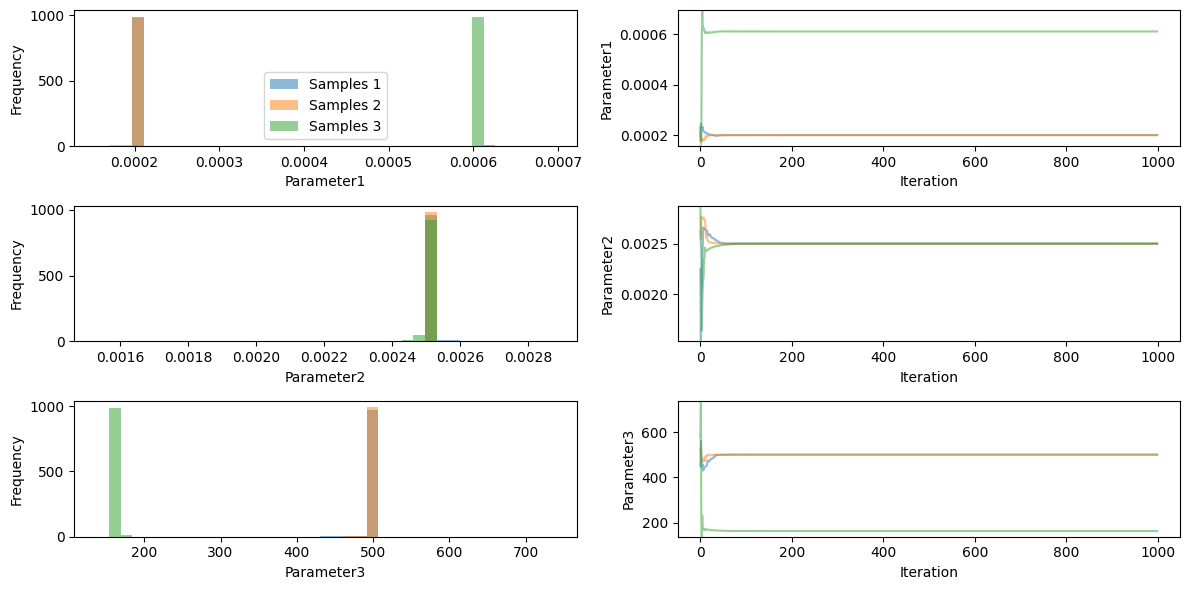

<class '__main__.MyMCMCSummary'>
param    mean      std.      2.5%    25%     50%     75%       97.5%     rhat      ess    ess per sec.
-------  --------  --------  ------  ------  ------  --------  --------  --------  -----  --------------
b        0.000337  0.000194  0.0002  0.0002  0.0002  0.000612  0.000612  2.92e+08  21.1   0.00242
p        0.0025    3.98e-11  0.0025  0.0025  0.0025  0.0025    0.0025    9.44      17.2   0.00197
N        388       159       163     163     500     501       501       7.2e+08   12.5   0.00144


In [22]:
pints.plot.trace(chains_1)
plt.savefig("perfect_data_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_1 = MyMCMCSummary(chains=chains_1[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_1))
print(results_1)

Multiplicative noise

In [23]:
noise = 1
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains_2 = mcmc.run()
print(chains_2)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_72059/4095664220.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     189     0:05.4
2     330     0:09.0
3     465     0:11.3
20    2235    0:45.5
40    4026    1:17.7
60    5799    1:48.8
80    7593    2:20.6
100   9363    2:52.4
120   11154   3:23.8
140   12948   3:55.4
160   14748   4:27.3
180   16569   5:00.6
200   18288   5:30.9
220   20178   6:04.5
240   21864   6:34.4
260   23718   7:07.8
280   25539   7:40.2
300   27357   8:12.3
320   29187   8:44.8
340   31044   9:18.0
360   32841   9:49.7
380   34647  10:31.0
400   36381  11:02.4
420   38115  11:34.1
440   39966  12:06.8
460   41787  12:38.1
480   43776  13:12.5
500   45600  13:44.6
520   47349  14:15.8
540   49161  14:47.4
560   50973  15:18.5
580   52692  15:48.8
600   54534  16:21.1
620   56232  16:51.3
640   57972  17:21.5
660   59844  17:54.1
680   61719  18:26.3
700   63546  18:59.3
720   65397  19:31.9
740   67230  20:04.1
760   69081  20:36.2
780   70932  21:08.5
800   72624  21:38.5
820   74382  22:09.3
840   76218  22:41.3
860   77934  23:11.1
880   79755  23:43.5
900   81570  

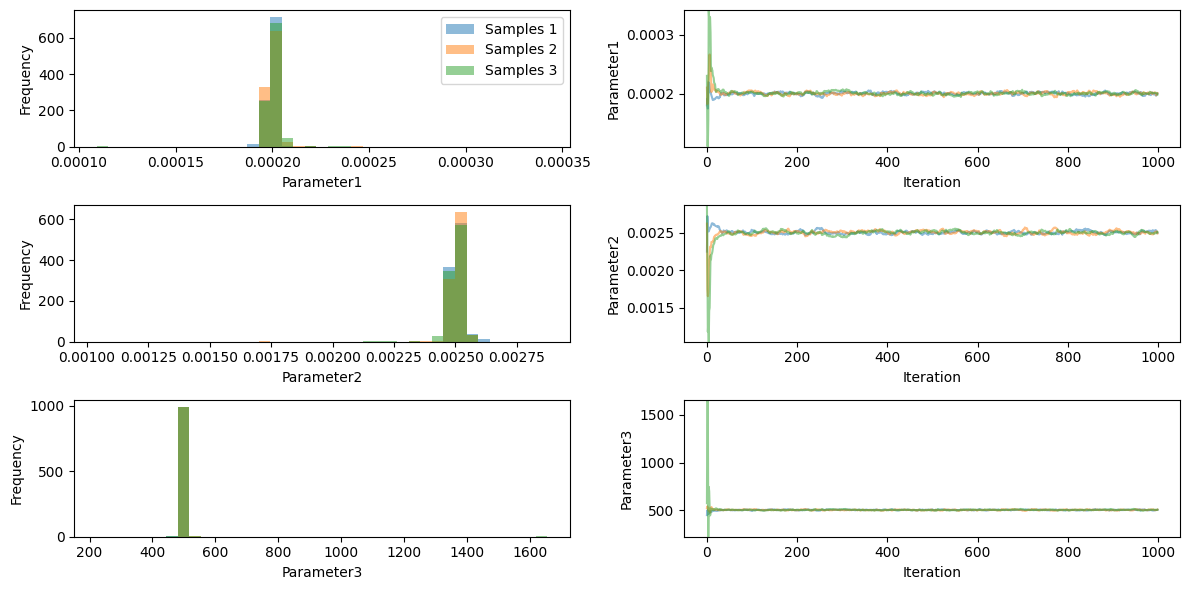

<class '__main__.MyMCMCSummary'>
param    mean     std.      2.5%      25%       50%      75%       97.5%     rhat    ess    ess per sec.
-------  -------  --------  --------  --------  -------  --------  --------  ------  -----  --------------
b        0.0002   2.1e-06   0.000196  0.000199  0.0002   0.000202  0.000204  1       95.3   0.0598
p        0.00251  1.98e-05  0.00247   0.00249   0.00251  0.00252   0.00255   1.01    81.8   0.0514
N        504      3.17      498       502       505      506       510       1.01    157    0.0982


In [24]:
pints.plot.trace(chains_2)
plt.savefig("noisy_data_multiplicative_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_2 = MyMCMCSummary(chains=chains_2[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_2))
print(results_2)

Additive noise

In [25]:
noise = 1
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains_3 = mcmc.run()
print(chains_3)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.1


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_72059/3189338596.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     156     0:03.5
2     273     0:05.9
3     369     0:07.8
20    2244    0:40.7
40    5133    1:31.5
60    8742    2:34.7
80    12516   3:41.1
100   16296   4:47.0
120   20028   5:52.4
140   23586   6:54.4
160   27390   8:00.9
180   31068   9:05.0
200   34746  10:10.7
220   38331  11:13.3
240   42183  12:20.2
260   46071  13:28.2
280   49815  14:34.0
300   53505  15:38.7
320   57210  16:43.0
340   60792  17:45.0
360   64542  18:50.2
380   68241  19:55.2
400   71886  20:58.2
420   75648  22:04.0
440   79248  23:06.7
460   82974  24:11.7
480   86772  25:17.8
500   90483  26:22.2
520   94218  27:27.7
540   97947  28:32.7
560   101604  29:36.2
580   105372  30:41.1
600   109020  31:43.7
620   112641  32:46.3
640   116490  33:52.3
660   120300  34:58.2
680   123924  36:00.8
700   127512  37:02.9
720   131130  38:05.6
740   134643  39:05.8
760   138267  40:08.6
780   141783  41:09.2
800   145488  42:12.8
820   149160  43:16.2
840   152967  44:23.1
860   156543  45:25.0
880   160152  46:2

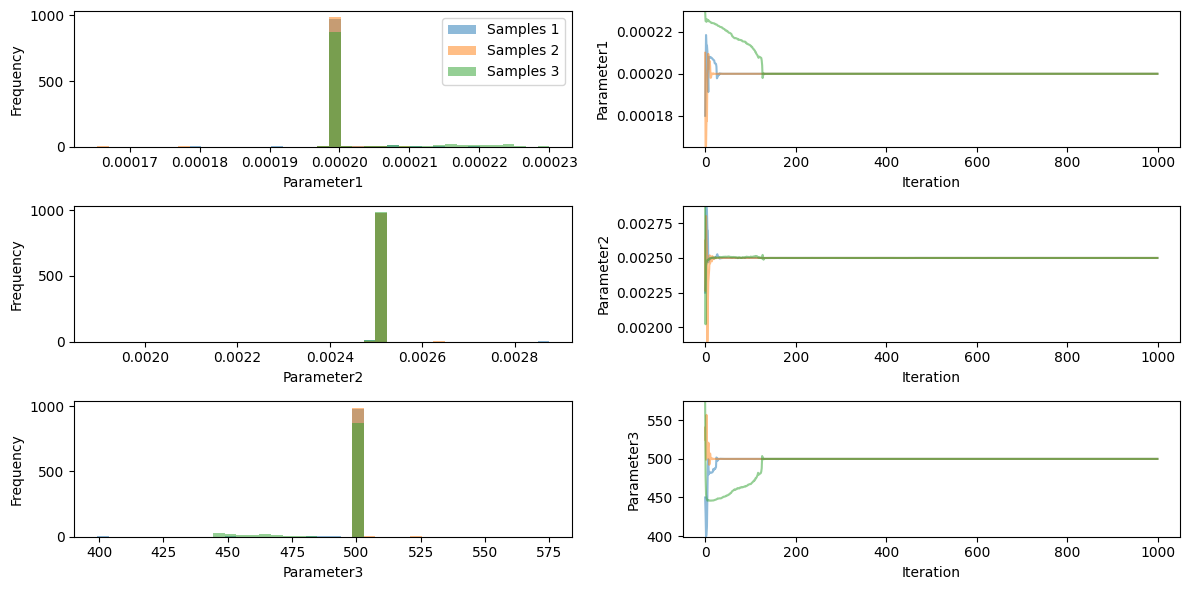

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  2.15e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1.01    336    0.107
p        0.0025  7.09e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1       427    0.136
N        500     0.00225   500     500     500     500     500      1.01    346    0.11


In [26]:
pints.plot.trace(chains_3)
plt.savefig("noisy_data_additive_moments_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results_3 = MyMCMCSummary(chains=chains_3[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results_3))
print(results_3)